In [2]:
import os
import sys
from math import pi, sqrt
import numpy as np
from numpy.random import rand
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd.functional import vjp, vhp, jacobian, hessian
from scipy.interpolate import RegularGridInterpolator


from torch.autograd import grad
from torch.autograd import Variable
from random import random, normalvariate
from sklearn.neighbors import NearestNeighbors

from model.utility import generate_data, histogramcnn, histtopdf,make_grid
from model.LLES import kernel

from copy import copy
torch.set_default_dtype(torch.float64)

# Train smoothing kernel first

# Setup LLES and PIML-SK model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Lagrangian data and Eulerian data for traning
load the trajectory of the Lagrangian particle to the variable pos_traj(position), vel_traj(velocity)

They should have the shape of (nparticle, 3) for velocity and position. In this notebook, nparticle = 262144

Load the corresponding Eulerian data at the same time step for both field and gradient, into variables train_value, train_gradient. The should have the shape (nfield, nfield, nfield, 3), nfield = 64. The data should sample on a [0,2*pi) domian uniformly



In [28]:
def read_HIT_data(device):
    loadData = np.load('dataset/HIT_Mt008_kernel_train.npz', allow_pickle=True)
    train_value = loadData['vel_grid']
    train_gradient = loadData['velgrad_grid']
    pos_traj = loadData['pos'].reshape([-1,3])
    vel_traj = loadData['vel_par'].reshape([-1,3])
    return torch.from_numpy(train_value).to(device), torch.from_numpy(train_gradient).to(device), torch.from_numpy(pos_traj).to(device), torch.from_numpy(vel_traj).to(device)

In [29]:
# Read HIT data for Mt= 0.08
train_value,train_gradient, pos_traj, vel_traj = read_HIT_data(device)

In [30]:
N = 64**3
dt = 0.05
tref = torch.tensor(0.1)
nfield = 64
nfieldt = 64**3
neighbor_kernel = 60

In [31]:
model = kernel(N, nfield, neighbor_kernel, device)

# Setup Eulerian-grid based Loss function

In [32]:
grid = make_grid(nfield)
grid = torch.tensor(grid).to(device)

In [33]:
#Pre-compute the neighborhood list for reconstructuing Eulerian data
model.update_neighborlist_sklearn(pos_traj,grid)

In [34]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [35]:
batch_size =int(nfieldt/128)
batch_number = int(nfieldt/batch_size)
batch_array = np.arange(nfieldt)
np.random.shuffle(batch_array)
batch_array=torch.tensor(batch_array.reshape([batch_number,batch_size]))

# First train with Trajectory-based and Statistics-based loss

In [42]:
train_epochs = 1
loss_traj = []

In [43]:
for i in range(train_epochs):
    for nb in range(batch_number):
        optimizer.zero_grad()
        # Compute the field and gradient for a minibatch
        pred, preddx= model.cal_f_nn(pos_traj,grid,vel_traj,train_value[:,0],batch_array[nb])
        #  Integral loss
        loss_integral = (1.0-model.cal_integral()).pow(2)
        
        #  Reconstruction loss
        l2loss = (pred-train_value[batch_array[nb]]).pow(2).mean()
        
        # Gradient reconstruction loss
        l2loss_grad = (preddx-train_gradient[batch_array[nb]]).pow(2).mean()
        
        
        # Smooth condition at r=0
        l2loss_drr = model.wnn_r_grad(torch.zeros(1).to(device)).pow(2)

        loss =  l2loss + l2loss_grad  + 0.1*loss_integral + 0.01*l2loss_drr
        loss.backward(retain_graph=True)

        optimizer.step()
        loss_traj.append(l2loss.cpu().detach().numpy())
        loss_traj.append(loss_integral.cpu().detach().numpy())
        loss_traj.append(l2loss_grad.cpu().detach().numpy())
        if nb%10 == 0:
            print("Epoch = {}  Total loss = {}".format(i, loss.cpu().detach().numpy()))
            print("Field loss = {} ".format(l2loss.cpu().detach().numpy()))
            print("Grad loss, vel = {}".format( l2loss_grad.cpu().detach().numpy()))
    scheduler.step()

Epoch = 0  Total loss = [[10.5266265]]
Field loss = 0.00011327786004544992 
Grad loss, vel = 0.021016228826932472
Epoch = 0  Total loss = [[6.22931951]]
Field loss = 0.00011195196504399459 
Grad loss, vel = 0.020488255138476574
Epoch = 0  Total loss = [[3.3619419]]
Field loss = 0.00012204562828380188 
Grad loss, vel = 0.02058410892072083
Epoch = 0  Total loss = [[1.67464002]]
Field loss = 0.0001169689636787107 
Grad loss, vel = 0.020280977637056087
Epoch = 0  Total loss = [[0.7892616]]
Field loss = 0.00011557497973008009 
Grad loss, vel = 0.020115898217236458
Epoch = 0  Total loss = [[0.37669187]]
Field loss = 0.0001127214290097866 
Grad loss, vel = 0.019711396146218294
Epoch = 0  Total loss = [[0.20895814]]
Field loss = 0.00011048286603518214 
Grad loss, vel = 0.019568052937991662
Epoch = 0  Total loss = [[0.15186424]]
Field loss = 0.00011196076367137445 
Grad loss, vel = 0.020262595130156005
Epoch = 0  Total loss = [[0.1355957]]
Field loss = 0.000113227668587499 
Grad loss, vel = 0.0

In [41]:
torch.save(model.cpu().state_dict(),"SmoothingKernel.params")
model.to(device)

kernel(
  (l1): Linear(in_features=1, out_features=20, bias=True)
  (l2): Linear(in_features=20, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=20, bias=True)
  (l4): Linear(in_features=20, out_features=1, bias=True)
  (act): Tanh()
)

# Check the quality of the reproduced field

In [44]:
with torch.no_grad():
    pred, preddx= model.cal_f_nn(pos_traj,grid,vel_traj,train_value[:,0],np.arange(nfieldt))

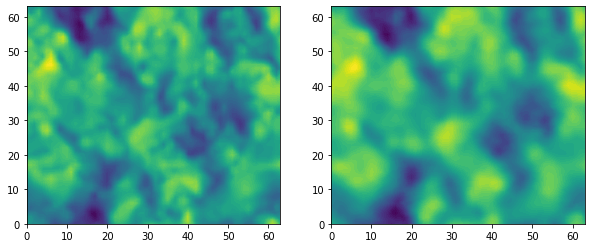

In [45]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].contourf(train_value.cpu().reshape([nfield,nfield,nfield,3])[:,:,10,0],levels=50)
ax[1].contourf(pred.cpu().reshape([nfield,nfield,nfield,3])[:,:,10,0], levels=50)